$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Course Project - Variance Networks
<a id=part3></a>

In this part we will explore convolution networks and the effects of their architecture on accuracy. We'll implement a common block-based deep CNN pattern and we'll perform various experiments on it while varying the architecture. Then we'll implement our own custom architecture to see whether we can get high classification results on a large subset of CIFAR-10.

Training will be performed on GPU.

In [9]:
import os
import re
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import unittest
import torch
import torchvision
import torchvision.transforms as tvtf

%matplotlib inline
%load_ext autoreload
%autoreload 2

seed = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

plt.rcParams.update({'font.size': 12})
test = unittest.TestCase()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Convolutional layers and networks
<a id=part3_1></a>

First we need to write some code to run the experiment.

**TODO**:
1. Implement the `run_experiment()` function in the `hw2/experiments.py` module.
1. If you haven't done so already, it would be an excellent idea to implement the **early stopping** feature of the `Trainer` class.

The following block tests that your implementation works. It's also meant to show you that each experiment run creates a result file containing the parameters to reproduce and the `FitResult` object for plotting.

In [13]:
import hw2.experiments as experiments
from hw2.experiments import load_experiment
from cs236605.plot import plot_fit

# Test experiment1 implementation on a few data samples and with a small model
experiments.run_experiment('test_run', seed=seed, bs_train=50, batches=10, epochs=10, early_stopping=5,
                           filters_per_layer=[32], layers_per_block=1, pool_every=1, hidden_dims=[100],ycn=True)

# There should now be a file 'test_run.json' in your `results/` folder.
# We can use it to load the results of the experiment.
cfg, fit_res = load_experiment('results/test_run.json')
_, _ = plot_fit(fit_res)

# And `cfg` contains the exact parameters to reproduce it
print('experiment config: ', cfg)

YourCodeNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): FlattenLayer()
    (8): LinearVarianceToy(in_features=720, out_features=500, bias=False)
    (9): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (10): ReLU()
    (11): Linear(in_features=500, out_features=10, bias=False)
  )
)
--- EPOCH 1/10 ---
train_batch (2.121):  56%|█████▌    | 674/1200 [00:05<00:04, 129.56it/s]


KeyboardInterrupt: 

We'll use the following function to load multiple experiment results and plot them together.

In [7]:
def plot_exp_results(filename_pattern, results_dir='results'):
    fig = None
    result_files = glob.glob(os.path.join(results_dir, filename_pattern))
    result_files.sort()
    if len(result_files) == 0:
        print(f'No results found for pattern {filename_pattern}.', file=sys.stderr)
        return
    for filepath in result_files:
        m = re.match('exp\d_(\d_)?(.*)\.json', os.path.basename(filepath))
        cfg, fit_res = load_experiment(filepath)
        fig, axes = plot_fit(fit_res, fig, legend=m[2],log_loss=True)
    del cfg['filters_per_layer']
    del cfg['layers_per_block']
    print('common config: ', cfg)

#### Experiment 1.1: Varying the network depth (`L`)

First, we'll test the effect of the network depth on training.

**Configuratons**:
- `K=32` fixed, with `L=2,4,8,16` varying per run
- `K=64` fixed, with `L=2,4,8,16` varying per run

So 8 different runs in total.

**Naming runs**:
Each run should be named `exp1_1_K{}_L{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_1_K32_L2`. 

**TODO**: Run the experiment on the above configuration. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_1_K32_L8', 'out_dir': './results', 'seed': 1939900059, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 100, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.0015, 'reg': 0.0002, 'pool_every': 2, 'hidden_dims': [256], 'ycn': False, 'kw': {}}


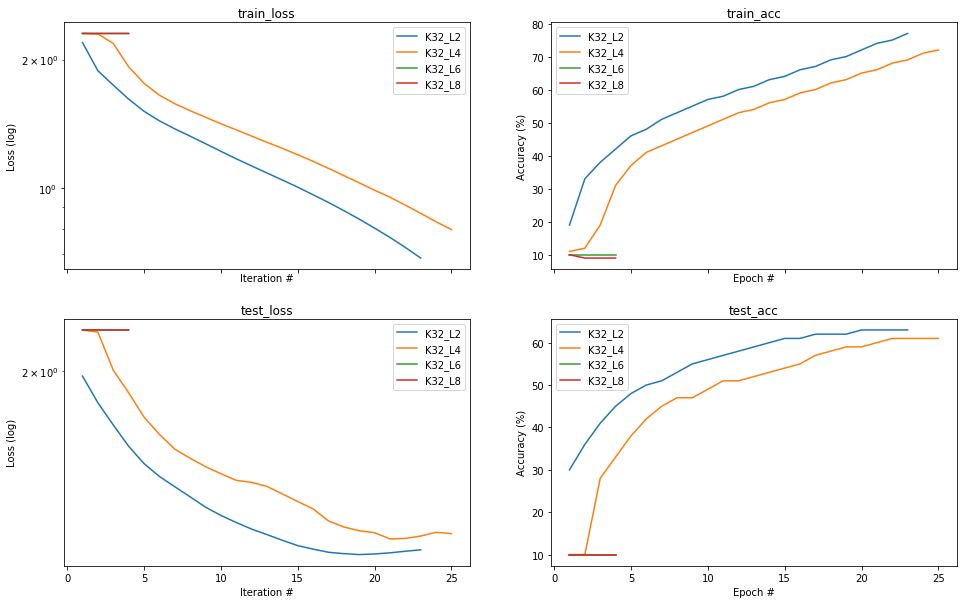

In [8]:
plot_exp_results('exp1_1_K32*.json')

common config:  {'run_name': 'exp1_1_K64_L8', 'out_dir': './results', 'seed': 1617313167, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 100, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.0015, 'reg': 0.0002, 'pool_every': 2, 'hidden_dims': [256], 'ycn': False, 'kw': {}}


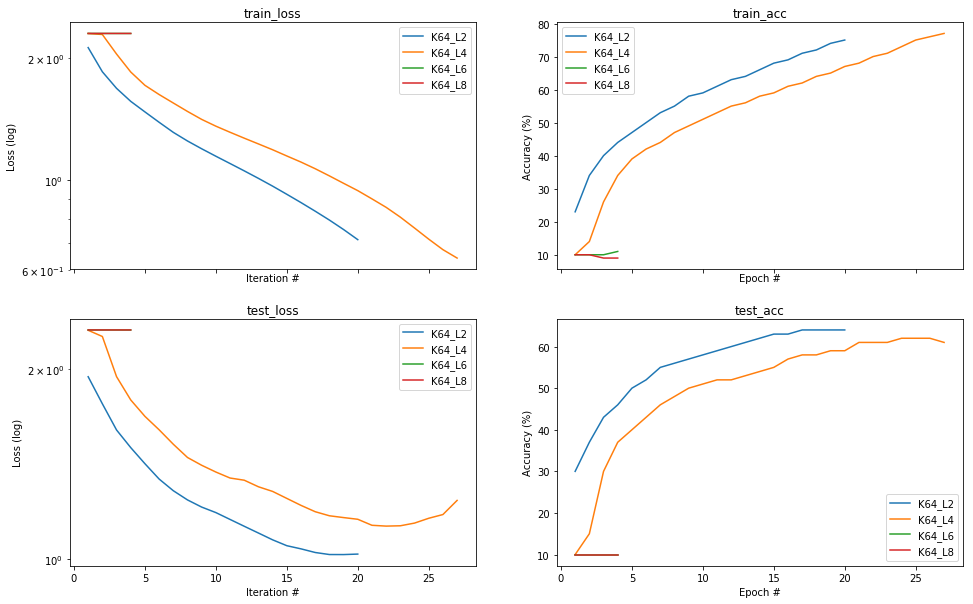

In [9]:
plot_exp_results('exp1_1_K64*.json')

#### Experiment 1.2: Varying the number of filters per layer (`K`)

Now we'll test the effect of the number of convolutional filters in each layer.

**Configuratons**:
- `L=2` fixed, with `K=[32],[64],[128],[258]` varying per run.
- `L=4` fixed, with `K=[32],[64],[128],[258]` varying per run.
- `L=8` fixed, with `K=[32],[64],[128],[258]` varying per run.

So 12 different runs in total. To clarify, each run `K` takes the value of a list with a single element.

**Naming runs**:
Each run should be named `exp1_2_L{}_K{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_2_L2_K32`. 

**TODO**: Run the experiment on the above configuration. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_2_L2_K64', 'out_dir': './results', 'seed': 1083508784, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 100, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.0015, 'reg': 0.0002, 'pool_every': 2, 'hidden_dims': [256], 'ycn': False, 'kw': {}}


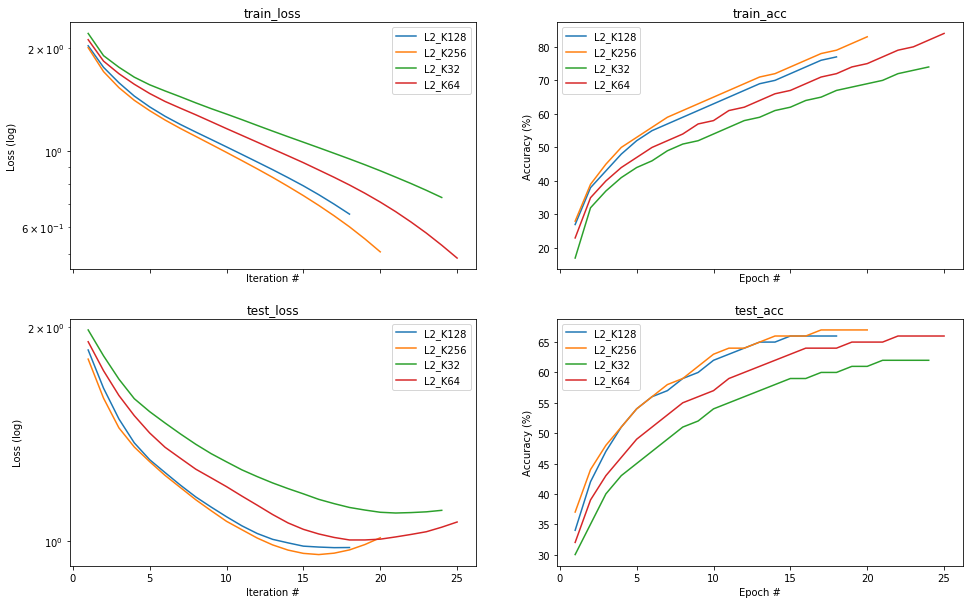

In [10]:
plot_exp_results('exp1_2_L2*.json')

common config:  {'run_name': 'exp1_2_L4_K64', 'out_dir': './results', 'seed': 1230240509, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 100, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.0015, 'reg': 0.0002, 'pool_every': 2, 'hidden_dims': [256], 'ycn': False, 'kw': {}}


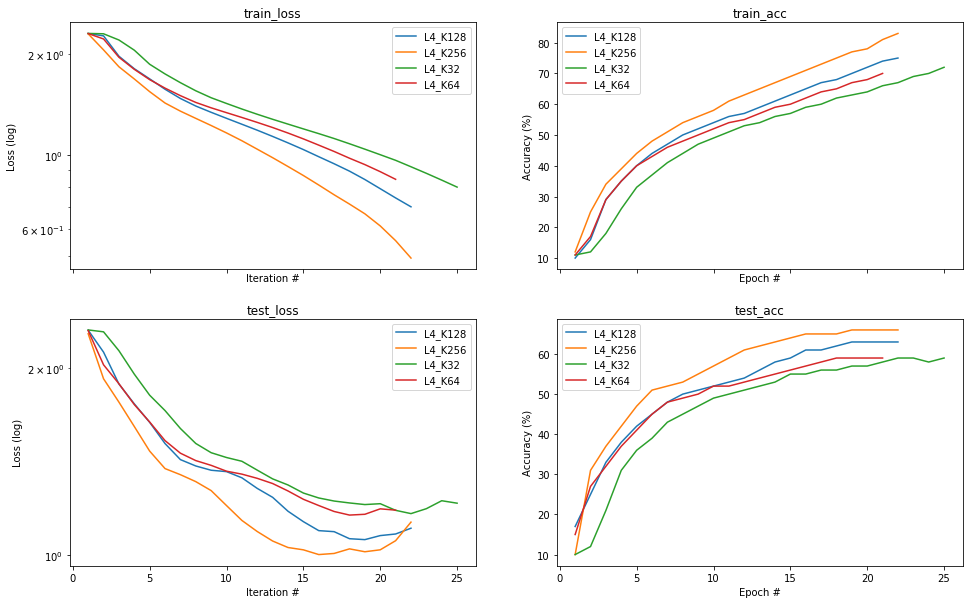

In [11]:
plot_exp_results('exp1_2_L4*.json')

common config:  {'run_name': 'exp1_2_L8_K64', 'out_dir': './results', 'seed': 22118528, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 100, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.0015, 'reg': 0.0002, 'pool_every': 2, 'hidden_dims': [256], 'ycn': False, 'kw': {}}


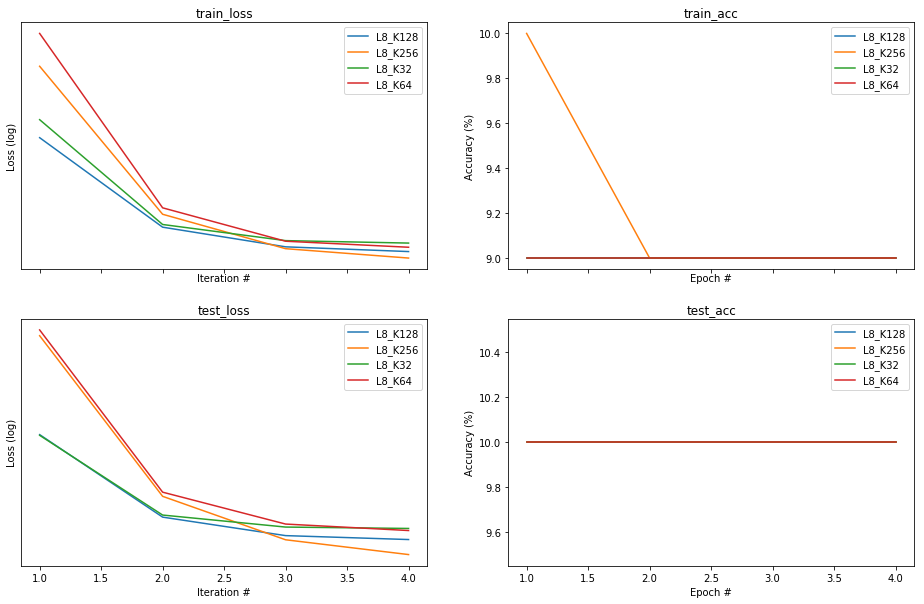

In [12]:
plot_exp_results('exp1_2_L8*.json')

#### Experiment 1.3: Varying both the number of filters (`K`) and network depth (`L`)

Now we'll test the effect of the number of convolutional filters in each layer.

**Configuratons**:
- `K=[64, 128, 256]` fixed with `L=1,2,3,4` varying per run.

So 4 different runs in total. To clarify, each run `K` takes the value of an array with a three elements.

**Naming runs**:
Each run should be named `exp1_3_L{}_K{}-{}-{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_3_L1_K64-128-256`. 

**TODO**: Run the experiment on the above configuration. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_3_L4_K64-128-256', 'out_dir': './results', 'seed': 479629706, 'bs_train': 64, 'bs_test': 16, 'batches': 100, 'epochs': 100, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.0015, 'reg': 0.0002, 'pool_every': 4, 'hidden_dims': [100], 'ycn': False, 'kw': {}}


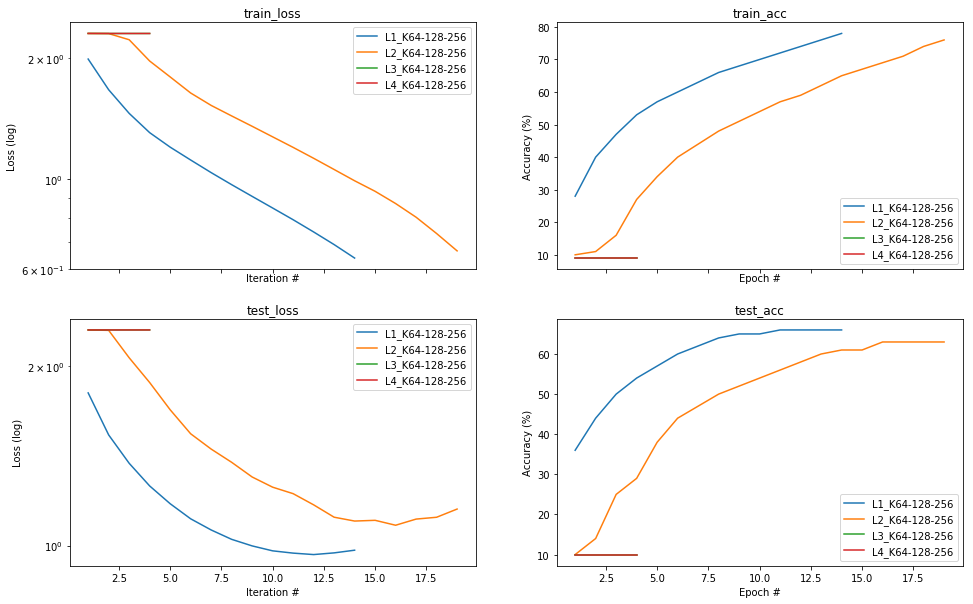

In [13]:
plot_exp_results('exp1_3*.json')

### Experiment 2 - Custom network architecture

In this part you will create your own custom network architecture based on the `ConvClassifier` you've implemented.

Try to overcome some of the limitations your experiment 1 results, using what you learned in the course.

You are free to add whatever you like to the model, for instance 
- Batch normalization
- Dropout layers
- Skip connections
- Change kernel spatial sizes and strides
- Custom blocks or ideas from known architectures

Just make sure to keep the model's `init` API identical (or maybe just add parameters).

**TODO**: Implement your custom architecture in the `YourCodeNet` class within the `hw2/models.py` module.

In [14]:
net = models.YourCodeNet((3,100,100), 10, filters=[32]*4, pool_every=2, hidden_dims=[100]*2).to(device)
print(net)

test_image = torch.randint(low=0, high=256, size=(3, 100, 100)).to(device)
test_out = net(test_image.unsqueeze(0))
print('out =', test_out)

YourCodeNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): 

#### Experiment 2 Configuration

Run your custom model on at least the following:

**Configuratons**:
- `K=[64, 128, 256, 512]` fixed with `L=1,2,3,4` varying per run.

So 4 different runs in total. To clarify, each run `K` takes the value of an array with a four elements.

If you want, you can add some extra following the same pattern.
Try to see how deep a model you can train.

**Naming runs**:
Each run should be named `exp2_L{}_K{}-{}-{}-{}` where the braces are placeholders for the values. For example, the first run should be named `exp2_L1_K64-128-256-512`. 

**TODO**: Run the experiment on the above configuration. Make sure the result file names are as expected. Use the following blocks to display the results. To make the experiment runner use your custom network model instead of the previous one, use the `--ycn` argument on the command line.

common config:  {'run_name': 'exp2_L4_K64-128-256-512', 'out_dir': './results', 'seed': 258617223, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 100, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.0003, 'reg': 0.0002, 'pool_every': 3, 'hidden_dims': [256], 'ycn': True, 'kw': {}}


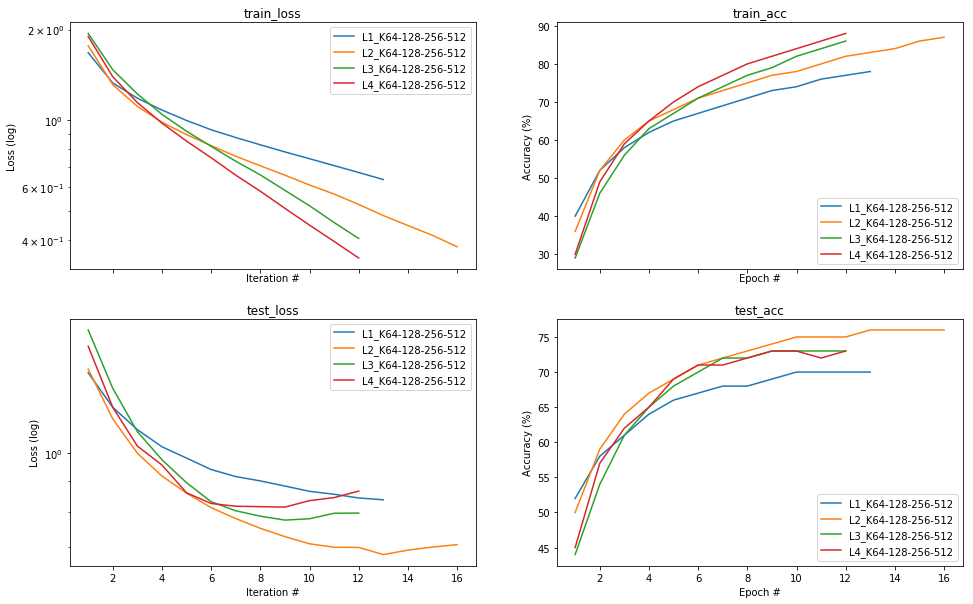

In [15]:
plot_exp_results('exp2*.json')

## Questions
<a id=part3_4></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw2/answers.py`.

In [16]:
from cs236605.answers import display_answer
import hw2.answers

### Question 1 

Analyze your results from experiment 1.1. In particular,
1.  Explain the effect of depth on the accuracy. What depth produces the best results and why do you think that's the case?
1. Were there values of `L` for which the network wasn't trainable? what causes this? Suggest two things which may be done to resolve it at least partially.

In [17]:
display_answer(hw2.answers.part3_q1)


**Your answer:**

The depth affects the accuracy because it expands the expressiveness of the network, if all calculations are smooth, we should be able to overfit the model
better with a deeper network, but we can see this isn't the case here.
The best results were encountered using a depth of 2.
The networks with depth 4 and 8 were unable to train.
This is because we experience a vanshing gradient; the deepest layers learn faster, and after they reach their minimum they backpropogate
a gradient which can no longer be optimized (a close to zero gradient).
The inputs to the deeper layers are a sum of the ones to the shallow layers, so as we get deeper the weights are much bigger, when backpropogating 
the gradient, the effect on the small weights of the shallow layers is minimal.

In order to eliminate there vanishing gradients, we can try to add batch normalization, to keep all weights similar, or to initialize the weights
with a smaller variance as a function of the number of inputs.



### Question 2 

Analyze your results from experiment 1.2. In particular, compare to the results of experiment 1.1.

In [18]:
display_answer(hw2.answers.part3_q2)


**Your answer:**

Here we again see that L8 was not able to train.
We can also see that more filters give us a better accuracy in every iteration. This can be explained because more filters give 
us more learnable parameters, so we are able to learn more from each run, thus we are more accurate in classification.
These extra learnable parameters also show in the test loss, where we can see in the last epochs that the loss is increasing, and the 
slope of increase is bigger for more filters. This is because more filters give us more of a chance to overfit.



### Question 3 

Analyze your results from experiment 1.3.

In [19]:
display_answer(hw2.answers.part3_q3)


**Your answer:**

In this experiment we are observing layers with increasing filters per layer. In a network like this, the first layer picks up the rougher features,
and going deeper the layers pick up finer and finer features.
We also notice the number of epochs to train was lower than the first two experiments.
Again, when the network is too deep we are unable to train it, due to similar issues as in experiment 1.1, and the best results are seen in the more shallow network.



### Question 4 

1. Explain your modifications to the architecture which you implemented in the `YourCodeNet` class.
2. Analyze the results of experiment 2. Compare to experiment 1.

In [20]:
display_answer(hw2.answers.part3_q4)


**Your answer:**


We added a dropout layer and batch normalization. Dropout improves generalization by adding randomness and prevents overfitting.
Batch normalization increases the stability of the calculation and makes it much faster.
We can see that adding these gave us much faster training times.
In the deeper models we are actually able to train as the normalization makes all of our calculations have stable values, and we do not
have vanishing gradients because of this.

